In [ ]:
import os
from pathlib import Path
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import random

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

Using device: cuda


In [3]:
COUNTRIES = ["Albania","Andorra","Argentina","Australia","Austria","Bangladesh","Belgium","Bhutan","Bolivia","Botswana","Brazil","Bulgaria","Cambodia","Canada","Chile","Colombia","Croatia","Czechia","Denmark","Dominican Republic","Ecuador","Estonia","Eswatini","Finland","France","Germany","Ghana","Greece","Greenland","Guatemala","Hungary","Iceland","Indonesia","Ireland","Israel","Italy","Japan","Jordan","Kenya","Kyrgyzstan","Latvia","Lesotho","Lithuania","Luxembourg","Malaysia","Mexico","Mongolia","Montenegro","Netherlands","New Zealand","Nigeria","North Macedonia","Norway","Palestine","Peru","Philippines","Poland","Portugal","Romania","Russia","Senegal","Serbia","Singapore","Slovakia","Slovenia","South Africa","South Korea","Spain","Sri Lanka","Sweden","Switzerland","Taiwan","Thailand","Turkey","Ukraine","United Arab Emirates","United Kingdom","United States","Uruguay"]
num_classes = len(COUNTRIES)

print("Number of classes:", num_classes)

Number of classes: 79


In [4]:
# load pre-trained model
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

model_path = "../models/resnet_finetuned/main.pth"
model.load_state_dict(torch.load(model_path, map_location=device))

model = model.to(device)

model.eval()

/tmp/ipykernel_1189737/2797976825.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

/home/andreafabbricatore/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


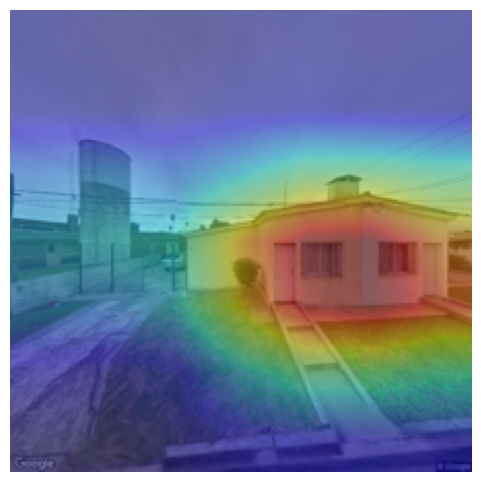

In [ ]:
def gradCAM(test_root, model, device):
    """
    test_root: folder of per-country subfolders (test set)
    model: your fine-tuned ResNet model
    device: torch.device("mps" or "cuda" or "cpu")
    transform: preprocessing for the model (Resize, ToTensor, Normalize)
    classes: list of class labels indexed by model output
    """

    # 0) Hook containers
    activations = gradients = None

    # 1) Hook callbacks
    def forward_hook(module, inp, outp):
        nonlocal activations
        activations = outp.detach()
    def backward_hook(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0].detach()

    # 2) Attach hooks to the last ResNet conv layer
    target_layer = model.layer4[-1].conv3
    handle_f = target_layer.register_forward_hook(forward_hook)
    handle_b = target_layer.register_full_backward_hook(backward_hook)

    # 3) Pick a random test image + ground truth
    country_dirs = [d for d in test_root.iterdir() if d.is_dir()]
    true_country = random.choice(country_dirs).name
    img_path = random.choice(list((test_root/true_country).glob("*.jpg")))
    orig = Image.open(img_path).convert("RGB")
    # Keep a display copy
    disp = orig.resize((224,224), Image.BILINEAR)

    # 4) Preprocess and forward for classification (no no_grad!)
    model.to(device).eval()
    inp = transform(orig).unsqueeze(0).to(device)

    # Zero grads before forward
    model.zero_grad()
    outputs = model(inp)               # <-- no torch.no_grad() here!
    pred_idx = outputs.argmax(dim=1).item()
    pred_label = COUNTRIES[pred_idx]

    # 5) Backward on the predicted class score
    score = outputs[0, pred_idx]
    score.backward()

    # 6) Build Grad-CAM
    weights = gradients.mean(dim=(2,3), keepdim=True)    # (1, C, 1, 1)
    cam_map = F.relu((weights * activations).sum(dim=1, keepdim=True))
    cam_map = F.interpolate(cam_map,
                            size=inp.shape[2:],
                            mode='bilinear',
                            align_corners=False)
    cam = cam_map.squeeze().cpu().numpy()
    cam = (cam - cam.min())/(cam.max()-cam.min()+1e-8)

    # 7) Plot side-by-side
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))

    # Original + labels
    ax1.imshow(disp)
    ax1.set_title(f"True: {true_country}\nPred: {pred_label}")
    ax1.axis('off')

    # Grad-CAM overlay
    img_np = np.array(disp)/255.0
    heatmap = plt.cm.jet(cam)[...,:3]
    overlay = 0.4*heatmap + 0.6*img_np
    ax2.imshow(overlay)
    ax2.set_title("Grad-CAM")
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

    # 8) Remove hooks
    handle_f.remove()
    handle_b.remove()


## More insights

/home/andreafabbricatore/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


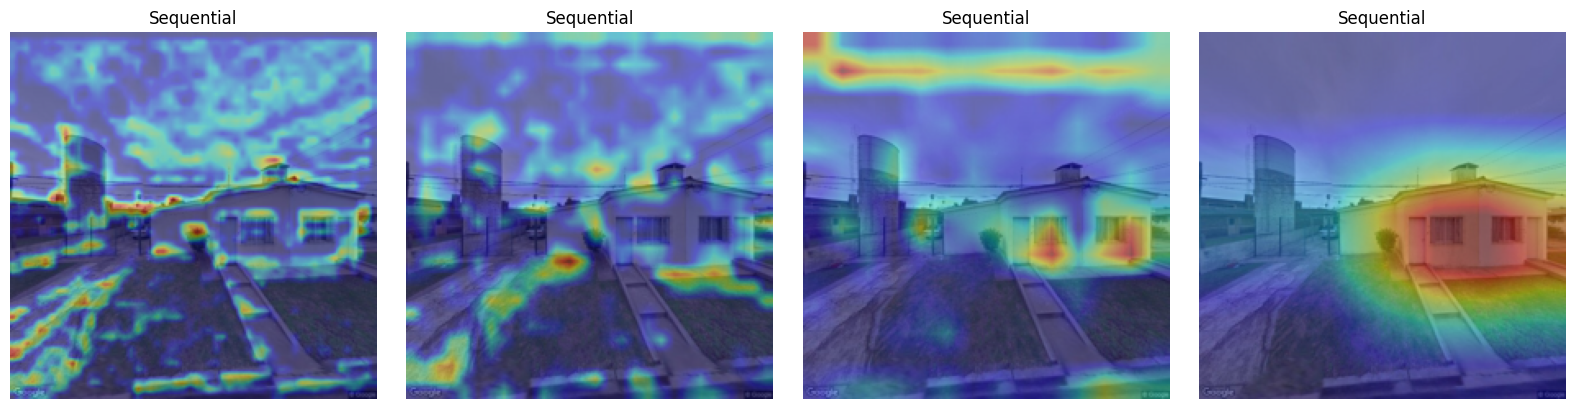

In [ ]:

# 1) Load pretrained model and set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = models.resnet50(pretrained=True).to(device).eval()

# 2) Preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# 3) Helper: get activations & gradients from a layer
def get_gradcam_fn(layer):
    activations, gradients = {}, {}
    def forward_hook(m, i, o):
        activations['val'] = o.detach()
    def backward_hook(m, gi, go):
        gradients['val'] = go[0].detach()
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    return activations, gradients

# 4) Grad-CAM generator
def gradcam(activations, gradients, class_idx, img_size):
    weights = gradients.mean(dim=[2,3], keepdim=True)
    cam = F.relu((weights * activations).sum(dim=1, keepdim=True))
    cam = F.interpolate(cam, img_size, mode='bilinear', align_corners=False)
    cam = cam.squeeze().cpu().numpy()
    cam = (cam - cam.min())/(cam.max()-cam.min()+1e-8)
    return cam

# 5) Load & preprocess a single image
img_pil = Image.open("/home/andreafabbricatore/rainbot/datasets/final_datasets/train/Uruguay/Uruguay_64.jpg").convert("RGB")
input_tensor = preprocess(img_pil).unsqueeze(0).to(device)

# 6) Choose layers to visualize
layers = [model.layer1, model.layer2, model.layer3, model.layer4]
fig, axes = plt.subplots(1, len(layers), figsize=(16,4))
axes = axes.flatten()

for ax, layer in zip(axes, layers):
    acts, grads = get_gradcam_fn(layer)
    # forward + backward for predicted class
    scores = model(input_tensor)
    pred = scores.argmax(dim=1).item()
    model.zero_grad(); scores[0,pred].backward()
    cam = gradcam(acts['val'], grads['val'], pred, input_tensor.shape[2:])
    heatmap = plt.cm.jet(cam)[..., :3]
    img_pil = img_pil.resize((224, 224), Image.BILINEAR)
    overlay = 0.4*heatmap + 0.6*np.array(img_pil)/255.0
    ax.imshow(overlay); ax.axis('off')
    ax.set_title(layer.__class__.__name__)

plt.tight_layout()
plt.show()
